TRIGRAM

All pairs of characters encoded in a single token

As numbers of "ngrams" grow this approach becomes more computationally expensive.

Alternatively -- build an embedding: 
- vocab of characters
- a LIST of chars indexes is mapped to an "embedding vector"

"hello"
"[42,2,7,7,10] => [0.1,0.1,0.1,0.4,0.5]"

In [1]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
words = open('names.txt', 'r').read().splitlines()
g = torch.Generator().manual_seed(2147483647)

In [5]:
# Shuffle the original list randomly
import random
random.shuffle(words)

# Get the length of the list
n = len(words)

# Calculate the sizes of the three parts
size_1 = int(n * 0.8)
size_2 = int(n * 0.1)
size_3 = n - size_1 - size_2

# Split the original list into three parts
train_words = words[:size_1]
dev_words = words[size_1:size_1+size_2]
test_words = words[size_1+size_2:]

test_words[:3]

train_words

['shin',
 'maryse',
 'emari',
 'rozalynn',
 'tayshawn',
 'aliia',
 'selim',
 'kiko',
 'titus',
 'arda',
 'kaitlen',
 'mylynn',
 'ivory',
 'helaina',
 'sulamita',
 'khodi',
 'callaway',
 'benjamin',
 'dariana',
 'kylie',
 'makynzee',
 'kehlani',
 'dempsey',
 'clark',
 'natalea',
 'heilyn',
 'calder',
 'elilta',
 'zatanna',
 'samary',
 'konner',
 'osvaldo',
 'sujay',
 'frederick',
 'zaria',
 'decland',
 'lilikoi',
 'sosuke',
 'mirely',
 'sibel',
 'shelton',
 'deziya',
 'zayley',
 'elora',
 'dominico',
 'aynoor',
 'raea',
 'aryaan',
 'isaak',
 'arro',
 'traniyah',
 'zeplin',
 'ilian',
 'caledonia',
 'yazmina',
 'conway',
 'kailee',
 'preslynn',
 'dereka',
 'marlaya',
 'german',
 'icelynn',
 'ayush',
 'jeice',
 'ovee',
 'helder',
 'addam',
 'victorious',
 'baptiste',
 'kavish',
 'dovi',
 'braelon',
 'lex',
 'uziel',
 'kayler',
 'amariana',
 'tayla',
 'lumiere',
 'eveanna',
 'aristeo',
 'ashton',
 'lelend',
 'muzamil',
 'vannessa',
 'annamary',
 'daylon',
 'tylann',
 'skarlette',
 'humna',


In [6]:
ngram_size = 3

In [7]:
# build vocab
chars = sorted(list(set(''.join(words) + ".")))

# build output stoi - the one we receive from the NN output [0..26]
output_stoi = {}
code = 0

for i,c1 in enumerate(chars):
  output_stoi[c1] = code
  code += 1

output_itos = {i:s for s,i in output_stoi.items()}

# build input stoi - a pair of characters to an integer
code = 0
stoi = {}
for i,c1 in enumerate(chars):
  for j,c2 in enumerate(chars):
    key = c1 + c2
    stoi[key] = code
    code += 1

itos = {i:s for s,i in stoi.items()}

stoi

vocab_size = len(stoi)
vocab_size

729

In [8]:
def add_padding(word, n):
  return '.'*n + word + '.'*n

def sliding_window(lst, n):
    """
    Returns a list of size N groupings from the given list using sliding window
    """
    return [lst[i:i+n] for i in range(len(lst)-n+1)]
    
def padded_sliding_window(input, n):
  padded = add_padding(input, n - 1)
  return sliding_window(padded, n)

def get_data(data_type):
    xs, ys = [], []
    numz = 0
    for w in data_type:
        examples = padded_sliding_window(w, ngram_size)
        for example in examples:
          input = example[:ngram_size - 1]
          output = example[-1]
          xs.append(stoi[input])
          ys.append(output_stoi[output])
          numz += 1
    
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys, numz
  
def initW(x, y):
  return torch.randn((x, y), requires_grad=True, generator=g)

def forwardPass(input, n, w):
  logits = W[input[torch.arange(n)]] # xenc @ W
  counts = logits.exp()
  probs = counts / counts.sum(dim=-1, keepdim=True)
  return probs

def calculateLoss(probs, n, ys, w):
  return -torch.log(probs[torch.arange(n), ys].mean()) + 1*(w**2).mean() 

def evaluate(xs, ys, n, w):
  probs = forwardPass(xs, n, w)
  return calculateLoss(probs, n, ys, w)

In [9]:
train_xs, train_ys, train_numz = get_data(train_words)
dev_xs, dev_ys, dev_numz = get_data(dev_words)
test_xs, test_ys, test_numz = get_data(test_words)


In [10]:

# init the net
W = initW(vocab_size, 27)



In [11]:
# optimization!
losses = []
for i in range(2000):
  loss = evaluate(train_xs, train_ys, train_numz, W)
  W.grad = None
  loss.backward()
  W.data += -10 * W.grad
  losses.append(loss.item())

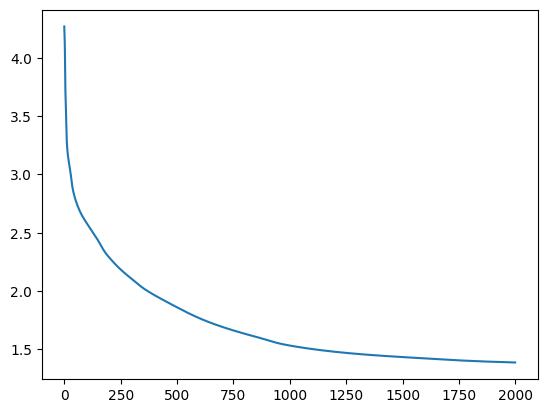

In [12]:
plt.plot(losses)

In [13]:
loss_on_train = evaluate(train_xs, train_ys, train_numz, W)
print("Loss on train:", loss_on_train)

loss_on_dev = evaluate(dev_xs, dev_ys, dev_numz, W)
print("Loss on dev:", loss_on_dev)

loss_on_test = evaluate(test_xs, test_ys, test_numz, W)
print("Loss on test:", loss_on_test)

Loss on train: tensor(1.3869, grad_fn=<AddBackward0>)
Loss on dev: tensor(1.3956, grad_fn=<AddBackward0>)
Loss on test: tensor(1.3953, grad_fn=<AddBackward0>)


In [14]:
# sample words
start = ".."
ix = stoi[start]
for i in range(10):
  name = ".."
  while True:
    input_gram = name[-2:]
    # print("gram: ", input_gram)
    ix = stoi[input_gram]
    probs = forwardPass([ix], 1, W) 
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    predicted_char = output_itos[ix]
    name += predicted_char
    if (predicted_char == '.'):
      break
  #print("resulting name", name)
  print(name)

..kah.
..kaya.
..kaylazhnbqpiya.
..kawnsiirey.
..kaivt.
..kaya.
..kah.
..ka.
..ka.
..kan.


In [15]:
# E03
reg_strengths = [ 0, 1, 5 ]
train_losses_per_s = {}
dev_losses_per_s = {}
for strength in reg_strengths:
  W = initW(vocab_size, 27)
  train_losses = []
  dev_losses = []
  for i in range(500):
    probs = forwardPass(train_xs, train_numz, W)
    loss = -torch.log(probs[torch.arange(train_numz), train_ys].mean()) + strength*(W**2).mean() 
    W.grad = None
    loss.backward()
    W.data += -50 * W.grad
    train_losses.append(loss.item())

    loss_on_dev = evaluate(dev_xs, dev_ys, dev_numz, W)
    dev_losses.append(loss_on_dev.item())

  train_losses_per_s[strength] = train_losses
  dev_losses_per_s[strength] = dev_losses

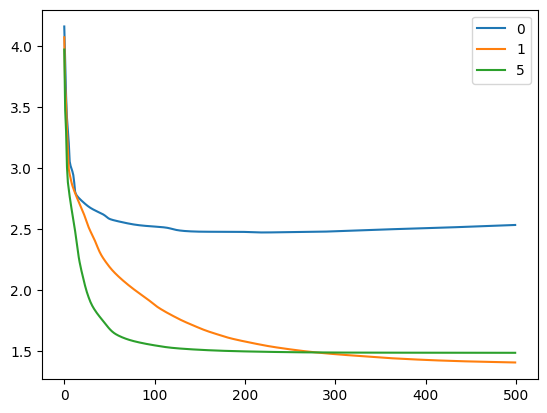

In [16]:
for s in reg_strengths:
  plt.plot(dev_losses_per_s[s], label = s)

plt.legend()

E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

Yes, 1.2

E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

Loss on dev: tensor(1.20, grad_fn=<AddBackward0>)
Loss on test: tensor(1.22, grad_fn=<AddBackward0>)

UPD: Looking back at this - not sure how I got these results, currently can't get lower than 1.34

E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

Surprisingly, the strength of 1 results in the better loss. 0 is the worse. 5 is too much as it stays at 2.5 loss after 100 iterations

With strength 1
  2000 epochs with -50 speed
  2000 epochs with -10 speed

Loss on test: 1.35


E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

yes, replaced with indexing, much faster


E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?


E06: meta-exercise! Think of a fun/interesting exercise and complete it.